# Ecological Index - regional scalings
- Calculate "present day" ecological index values from CESM2 hindcast MARBL NPP, KGP, & FEISTY (demersal only), and satellite derivations of penguin (EP and AP).
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

## How to make ecoindex

- Verify that spatial dimensions (lat/lon) are identical for each input
- Use the JRA55 1deg hindcast data (Krumhardt et al. 2024 - in review) that has been validated for BGC and sea ice for the CESM2 hindcast data.
- "Present day" index covers a range of current conditions in observations. Thus, for CESM hindcast data use averages from 2000-2020 for the inputs.
- Calculate ecoindex by summing all inputs. We've weighted each input equally, but could do sums of just some inputs of value (e.g. MARBL only, FEISTY + MARBL, PENGINS only).
- Only need CCAMLR MPA regions: 1 (Peninsula), 3 (Weddell), 4 (E Weddell), 7 (E. Ant), 8 (Ross), 9 (Bellingshausen and Amundsen)
- Check and test both global and regional scaling **for the EcoIndex only** (not inputs), so each region should have an ecoindex of 1 that shows the maximum *in that region*. We want to see most valuable regions around whole continent and within regions.  This is relevant because management is done regionally by CCAMLR.
- We use maximum value to scale so that the range is 0-1 for Ecoindex. We also tried scaling by median but that didn't really change where was most valuable, just the scaling, so stick with maximum value for ease of communication.


## Load data

We're slicing the data so it conforms to this latitude range in the southern hemisphere
- lat_min = -80
- lat_max = -60

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_mask = ds_mask.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# Read in 
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
#ds_ccamlr = ds_ccamlr.rename({'lat':'nlat','lon': 'nlon'})
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load the CESM2 hindcast sea ice zone data
- This is needed to mask the CESM2 hindcast based data so we find maximum **only within the SIZ** (want to mask high NPP north of ACC)

In [12]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [13]:
# load SIZ
file_in = 'CESM2-JRA55-hindcast-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

In [14]:
#check time index
ds_siz.isel(time=slice(42,63)).time

<xarray.DataArray 'time' (time: 21)>
array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019 2020

### Load Net Primary Productivity (NPP) data

In [16]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [17]:
# load NPP
file_in = 'CESM2-JRA55-hindcast-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
npp = ds_npp.NPP_ONDJFM

In [18]:
# keep only points in the SIZ by year
npp_mask = npp.where(ds_siz.SIZ_SEP == 1)

In [19]:
# scale this yearly data by maximum value in whole domain
data = npp_mask
scale_value = data.max(dim=['nlat','nlon'])
npp_scaled = data/scale_value

# mask to omit land points
npp_scaled = npp_scaled.where(ds_grid.REGION_MASK == 1)

In [20]:
# do averaging from 2000-2020
npp_scaled = npp_scaled.isel(time=slice(42,63)).mean(dim='time')

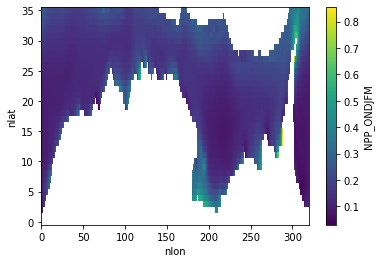

In [21]:
npp_scaled.plot()

### Load Krill Growth Potential (KGP) data

In [22]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [23]:
# load KGP
file_in = 'CESM2-JRA55-hindcast-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
kgp = ds_kgp.KGP_ONDJFM

In [24]:
# keep only points in the SIZ by year
kgp_mask = kgp.where(ds_siz.SIZ_SEP == 1)

In [25]:
# scale this yearly data by maximum value in whole domain
data = kgp_mask
scale_value = data.max(dim=['nlat','nlon'])
kgp_scaled = data/scale_value

# mask to omit land points
kgp_scaled = kgp_scaled.where(ds_grid.REGION_MASK == 1)

In [26]:
# do averaging from 2000-2020
kgp_scaled = kgp_scaled.isel(time=slice(42,63)).mean(dim='time')

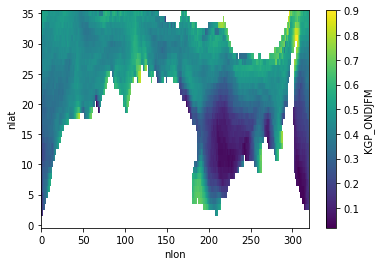

In [27]:
kgp_scaled.plot()

### Load FEISTY fish data (use demersal fish layer only)

In [28]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [29]:
# load FIESTY data
file_in = 'CESM2-JRA55-hindcast-annual-mean-FEISTY.nc'
ds_feisty = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
demersal = ds_feisty.Demersal

In [30]:
# keep only points in the SIZ by year
demersal_mask = demersal.where(ds_siz.SIZ_SEP == 1)

In [31]:
# scale this yearly data by maximum value in whole domain
data = demersal_mask
scale_value = data.max(dim=['nlat','nlon'])
demersal_scaled = data/scale_value

# mask to omit land points
demersal_scaled = demersal_scaled.where(ds_grid.REGION_MASK == 1)

In [32]:
# do averaging from 2000-2020
demersal_scaled = demersal_scaled.isel(time=slice(42,63)).mean(dim='time')

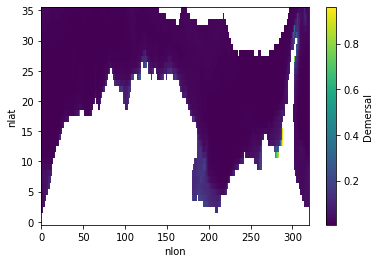

In [33]:
demersal_scaled.plot()

### Load the Emperor Penguin data

- Use the present day satellite based estimates # individuals (Larue et al. 2024, https://doi.org/10.1098/rspb.2023.2067)
- Calculated accessibility by using average foraging distance and having exponential decay from each colony

In [34]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [35]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_individual_access_present_day.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

In [36]:
total_ep = ds_ep.total_penguins

In [37]:
# scale this data by maximum value in whole domain
data = total_ep
scale_value = data.max(dim=['nlat','nlon'])
ep_scaled = data/scale_value

# mask to omit land points
ep_scaled = ep_scaled.where(ds_grid.REGION_MASK == 1)

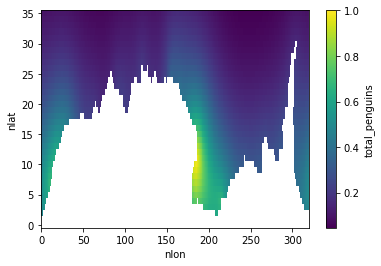

In [38]:
ep_scaled.plot()

### Load the Adelie Penguin data

- Use the present day satellite based estimates # individuals (Lynch and LaRue 2014, https://doi.org/10.1642/AUK-14-31.1).
- Calculated accessibility by using maximum dispersal distance and having exponential decay from each colony

In [39]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [40]:
# load Adelie Penguin distances
file_in = 'CESM_grid_Adelie_individual_access_present_day.nc'
ds_ap = xr.open_dataset(path_in+file_in, decode_times=True)

In [41]:
total_ap = ds_ap.total_penguins

In [42]:
# scale this data by maximum value in whole domain
data = total_ap
scale_value = data.max(dim=['nlat','nlon'])
ap_scaled = data/scale_value

# mask to omit land points
ap_scaled = ap_scaled.where(ds_grid.REGION_MASK == 1)

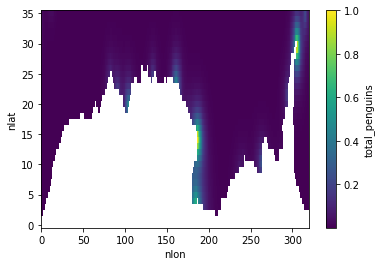

In [43]:
ap_scaled.plot()

## Make ecoindex
- Calculate ecoindex by summing all inputs

In [44]:
# sum all inputs
ecoind_raw = npp_scaled + kgp_scaled + demersal_scaled + ep_scaled + ap_scaled

### Scale pan Antarctic

In [45]:
# scale this data by maximum value in whole domain
scale_value = ecoind_raw.max(dim=['nlat','nlon'])
ecoind_hemispheric = ecoind_raw/scale_value

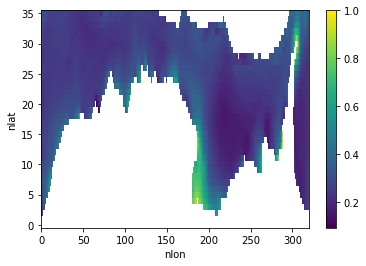

In [46]:
ecoind_hemispheric.plot()

### Scale by region

In [47]:
## Scale ecoindex by maximum values in each CCAMLR region
data = ecoind_raw

# find the scale value by year and member and zone
scale_value_1 = data.where(ccamlr_masks.sel(region='mpa_plan_1_mod')==1).max(dim=['nlat','nlon'])
scale_value_3_4 = data.where(ccamlr_masks.sel(region='mpa_plan_3_4')==1).max(dim=['nlat','nlon'])
scale_value_7 = data.where(ccamlr_masks.sel(region='mpa_plan_7_mod')==1).max(dim=['nlat','nlon'])
scale_value_8 = data.where(ccamlr_masks.sel(region='mpa_plan_8')==1).max(dim=['nlat','nlon'])
scale_value_9 = data.where(ccamlr_masks.sel(region='mpa_plan_9')==1).max(dim=['nlat','nlon'])

# scale all values by year and member
var_scaled_1 = data.where(ccamlr_masks.sel(region='mpa_plan_1_mod')==1)/scale_value_1
var_scaled_3_4 = data.where(ccamlr_masks.sel(region='mpa_plan_3_4')==1)/scale_value_3_4
var_scaled_7 = data.where(ccamlr_masks.sel(region='mpa_plan_7_mod')==1)/scale_value_7
var_scaled_8 = data.where(ccamlr_masks.sel(region='mpa_plan_8')==1)/scale_value_8
var_scaled_9 = data.where(ccamlr_masks.sel(region='mpa_plan_9')==1)/scale_value_9

# replace missing values with 0
var_scaled_1 = var_scaled_1.fillna(0)
var_scaled_3_4 = var_scaled_3_4.fillna(0)
var_scaled_7 = var_scaled_7.fillna(0)
var_scaled_8 = var_scaled_8.fillna(0)
var_scaled_9 = var_scaled_9.fillna(0)

# sum all the ccamlr regions to get the eco index input
ecoind_regional = var_scaled_1+var_scaled_3_4+var_scaled_7+var_scaled_8+var_scaled_9

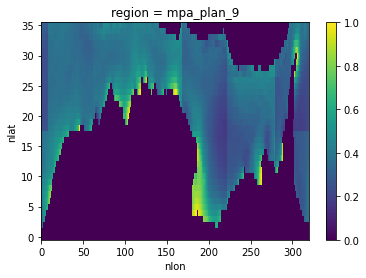

In [48]:
ecoind_regional.plot()

## Save File

- Netcdf with variable dimension: (nlat x nlon)
- Include TAREA, andd TLAT and TLONG as coordinates

In [49]:
ds_out = xr.Dataset()

ds_out['ecoindex_hemispheric'] = ecoind_hemispheric
ds_out['ecoindex_regional'] = ecoind_regional

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Ecological Index - present day historical reconstruction.'
ds_out.attrs['units'] = f'Unitless'

ds_out

<xarray.Dataset>
Dimensions:               (nlat: 36, nlon: 320)
Coordinates:
  * nlat                  (nlat) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
  * nlon                  (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 318.3 319.4
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... -60.52 -60.52
    ULONG                 (nlat, nlon) float64 321.1 322.3 323.4 ... 318.9 320.0
    ULAT                  (nlat, nlon) float64 -78.95 -78.95 ... -60.25 -60.25
    region                <U14 'mpa_plan_9'
Data variables:
    ecoindex_hemispheric  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ecoindex_regional     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-03
    contents:        Ecological Index - present day historical reconstruction.
    units:           Unitless

In [50]:
# drop unnecessary coordinates
ds_out = ds_out.drop('region')
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [51]:
ds_out

<xarray.Dataset>
Dimensions:               (nlat: 36, nlon: 320)
Coordinates:
  * nlat                  (nlat) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
  * nlon                  (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 318.3 319.4
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... -60.52 -60.52
Data variables:
    ecoindex_hemispheric  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ecoindex_regional     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-03
    contents:        Ecological Index - present day historical reconstruction.
    units:           Unitless

In [52]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201

In [53]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.00 GB.


In [54]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'
file_out = 'ecoindex_present_day.nc'
fout = path_out + file_out

In [56]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)